# Pythonopdracht week 1: Equalization and Interpolation

# Assignment 1.1: Histogram Equalization

## Working with notebooks

The assignments for this course will be given as Jupyter notebooks like this one. They will contain programming assignments which are automatically graded.

An autograded assignment will typically ask you to complete the code of a Python function. It is important that you do not change the name, inputs or outputs of the function, because they will be tested automatically: stick closely to the assignment. The autograder converts your notebook to a Python file by concatenating all code in the notebook and testing the resulting Python file. It is therefore important that your code runs correctly and uninterrupted, so:

**Always use `Kernel > Restart & Run All` and check the results before handing in your assignment**.

Some general tips:

- Avoid using packages that are not already imported in the assignment template, and are not default Python packages.
- Avoid using "notebook magic" like `%matplotlib inline`; such commands do not work when the notebook is converted to a Python script.

## Working with Codegrade

The assignments for this course are automatically graded by a system called *CodeGrade*. Our tests will run on your code automatically, and give grades based purely on the correctness of the output.

Some of the CodeGrade tests will be run immediately, and you can view the output/results before the deadline (it may take a couple of minutes to show up). Use this to check that your code is working correctly, and that you are in the right direction for the assignments.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread as skimread

## Point Operators

In the lecture notes a point operator is defined as an operator:
$$ 
\forall \mathbf x\in \mathcal D: \quad g(\mathbf x) = \psi(f(\mathbf x)),
$$
where $\psi$ is a scalar function taking in a gray value (real number) and returning a gray value (real number).

We will consider three different implementations of a point operator:

1. writing a function based on an analytical expression (e.g. $\psi(v)=v^2$),
2. in case the range of an image $f$ is a discrete and finite set of values (e.g. all pixel values are encoded as 8 bit integers) we can use a **look-up table**, and
3. in case an analytical expression is not available but only an (approximate) graph of the function $\psi$ we can use table interpolation.

## Gamma Correction

To warm up for the histogram equalization implementation later on, we first consider **gamma correction**. Let $f$ be a scalar image with gray values in the range from zero to one, then the gamma corrected image $g$ is defined as:
$$ 
\forall \mathbf x\in \mathcal D: \quad g(\mathbf x) = (f(\mathbf x))^\gamma
$$
With the usual overloading of operators we write:
$$ 
g = f^\gamma
$$
First, you have to write a function for the gamma correction. (In this case writing a function is unnecessarily complex, but we need it for automatic grading.)

In [2]:
def psi_gamma(f, gamma):
    """
    This function returns the array f^gamma: each value in the array f raised to the power gamma.

    Note: this function should not use (explicit) loops.
    """
    return np.array(f)**gamma

Assuming $f(\mathbf x)\in[0,1]\subset\mathbb{R}$ plot the graphs of $f^\gamma$ in one figure for values $\gamma \in\{ 0.3, 0.5, 0.7, 1, 1.43, 2.0, 3.33 \}$

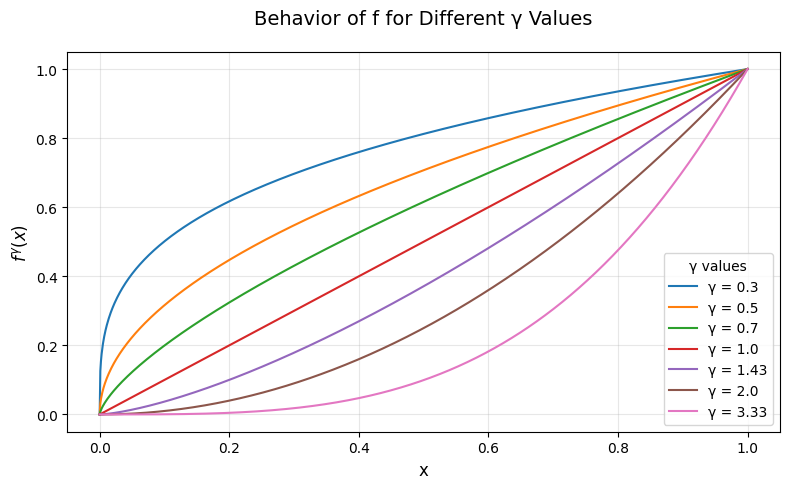

In [3]:
results = []
gammas = np.array([0.3, 0.5, 0.7, 1.0, 1.43, 2.0, 3.33])
x_values = np.linspace(0, 1, 1000)

plt.figure(figsize=(8, 5))

for gamma in gammas:
    y = psi_gamma(x_values, gamma)
    results.append(y)
    plt.plot(x_values, y, label=f"γ = {gamma}")

plt.xlabel('x', fontsize=12)
plt.ylabel('$f^γ(x)$', fontsize=12)
plt.title('Behavior of f for Different γ Values', fontsize=14, pad=20)
plt.grid(True, alpha=0.3)
plt.legend(title="γ values", fontsize=10)
plt.tight_layout()
plt.show()

Below an 'image' is shown where the gray values increase from zero to one going from left to right. Note that the perceptual difference between the lower gray values (darker tones) is smaller than the difference between the larger gray values.

<>:12: SyntaxWarning: invalid escape sequence '\g'
<>:12: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_63453/2597060378.py:12: SyntaxWarning: invalid escape sequence '\g'
  plt.title('$\gamma=%5.2f$' % gamma)


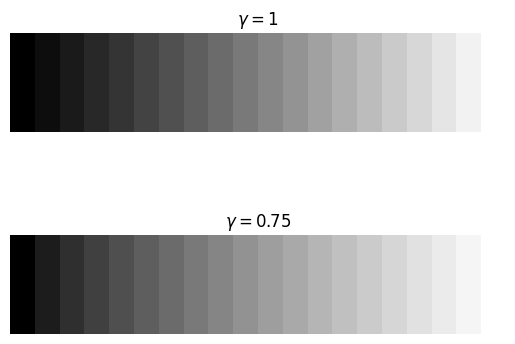

In [4]:
v = np.linspace(0, 1, 20)
f, _ = np.meshgrid(v, np.arange(4))
plt.subplot(2,1,1)
plt.imshow(f, vmin=0, vmax=1)
plt.title(r'$\gamma=1$')

plt.gray()
plt.axis('off')
plt.subplot(2,1,2)
gamma = 0.75
plt.imshow(psi_gamma(f, gamma), vmin=0, vmax=1);
plt.title('$\gamma=%5.2f$' % gamma)
plt.gray()
plt.axis('off');

Looking at the $\gamma$-curves you should be able to guestimate a value of $\gamma$ that will result in a more perceptually uniform change of luminance from left to right. Use this value as the $\gamma$ value in the code above for the second row and observe the results.

Looking at the plot, a value of $\approx 0.75$ results in the lower gray values being spaced out more, leading to a more perceptually uniform change of luminance from left to right.

## Table Lookup

A (unary) pixel operator can be implemented as a table lookup in case the range of the image is finite and countable. For an 8 bit image this is evidently the case: the possible pixels values are integers in the range from 0 to 255.

For such an 8 bit image the gamma correction from the previous section will not work because the gamma correction method assumes that the range is from zero to one. Rewrite the `psi_gamma` function to take an extra keyword argument `max_val` for images in the range from 0 to `max_val`. Note that the resulting image should have the same range from zero to `max_val`. Without special care the resulting image will have floating point values; that is ok for now.

In [5]:
def psi_gamma_scaled(v, gamma, max_val=1):
    return (np.array(v) / max_val)**gamma * max_val

Below we show two images. The original image 'trui' and a gamma corrected version of it. Note that we start with an image of dtype=uint8 and end up with an image of dtype=float64.

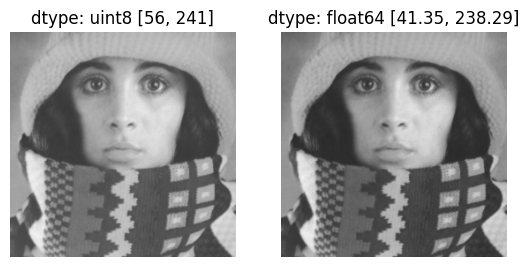

In [6]:
# The first time you run these tests, the code downloads the standard computer vision example image "trui.png".
try:
    f = skimread('trui.png')
except FileNotFoundError:
    import requests
    image_file = requests.get("https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_images/trui.png")
    open("trui.png", "wb").write(image_file.content)
    f = skimread('trui.png')

plt.subplot(1,2,1)
plt.imshow(f, vmin=0, vmax=255)
plt.axis('off')
plt.title(r'dtype: %s [%d, %d]' % (f.dtype, f.min(), f.max()))
plt.subplot(1,2,2)
g = psi_gamma_scaled(f, 1.2, max_val=255)
plt.imshow(g, vmin=0, vmax=255)
plt.title(r'dtype: %s [%5.2f, %5.2f]' % (g.dtype, g.min(), g.max()))
plt.axis('off');

Of course we can simply cast the resulting image into a dtype=uint8 image again but that would not prevent that the calculations (and intermediate images) are dtype=float64. Using a look-up table is one way to prevent that floating point intermediate values are used. 

In [7]:
def gamma_table_uint8(gamma):
    """returns a table (array) T of shape (256,)"""
    return (np.linspace(0, 1, 256) ** gamma * 256 - 1).astype(dtype=np.uint8)

The code below demonstrates the use of table lookup for gamma compression. Note that ``lut[f]`` does the table lookup for all pixels in the image. Read about the 'magic' of array indexing in Numpy to really understand this.

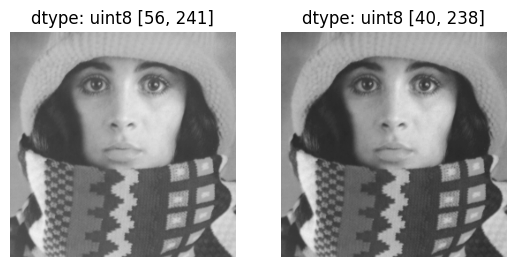

In [8]:
plt.subplot(1,2,1)
plt.imshow(f, vmin=0, vmax=255)
plt.axis('off')
plt.title(r'dtype: %s [%d, %d]' % (f.dtype, f.min(), f.max()))
plt.subplot(1,2,2)
lut = gamma_table_uint8(1.2)
g = lut[f]
plt.imshow(g, vmin=0, vmax=255)
plt.title(r'dtype: %s [%d, %d]' % (g.dtype, g.min(), g.max()))
plt.axis('off');

## Interpolated Table Lookup

A lookup table can only be used in case the set of pixel (gray) values is finite and discrete. For a floating point image a lookup table is not feasible.

Consider a point operator characterized with the function $\psi$:

$$
g(\mathbf x) = \psi(f(\mathbf x))
$$

with $f(\mathbf x)\in[0,1]\subset\mathbb{R}$.

Now let $\psi$ not be given in an analytical form but with just a few samples $\psi(v_i)=\psi_i$ (for $i=1,\ldots,n$). We assume $v_1=0$ and $v_n=1$ and furthermore we assume the sequence $v_i$ is increasing.

An example is given in the Python code below:

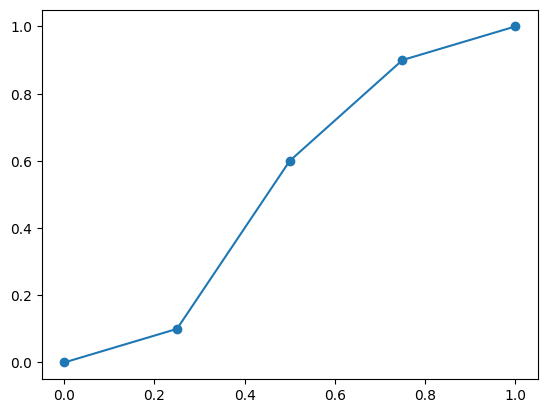

In [9]:
v = np.array([0, 0.25, 0.5, 0.75, 1])
psi = np.array([0, 0.1, 0.6, 0.9, 1])
plt.plot(v, psi, '-o');

Not only the five points $(v_i, \psi_i)$ are indicated but also the lines connecting the dots. This is called **linear interpolation**. In a subsequent lab exercise you will have to implement interpolation for 2D functions. Here we will use the Numpy ``interp`` function.

To get the value $\psi(0.6)$ through interpolation (given only the 5 points above) we can use:

0.72


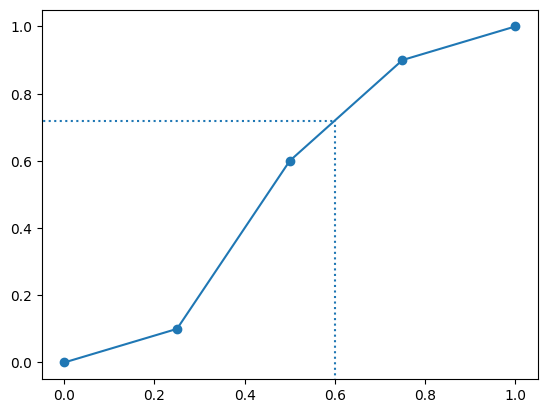

In [10]:
psi0p6 = np.interp(0.6, v, psi)
print(psi0p6)
plt.plot(v, psi, '-o')
axs = plt.axis()
plt.vlines(0.6, -1, psi0p6, linestyles='dotted')
plt.hlines(psi0p6, -1, 0.6, linestyles='dotted')
plt.axis(axs);

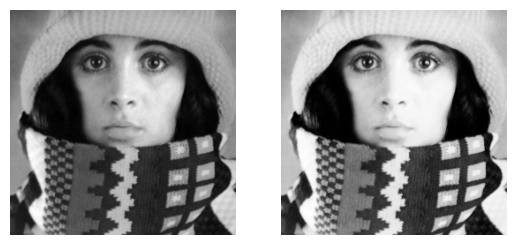

In [11]:
f = plt.imread('trui.png')
g = np.interp(f, v, psi)

plt.subplot(1,2,1)
plt.imshow(f);
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(g);
plt.axis('off');

Define the table $\psi_{\text{invert}}$ with as few points as possible to invert the image, i.e. $g = 1 - f$.

In [12]:
def invert_table():
    """returns a tuple (v, psi) defining a table to be used for
    interpolated table lookup that inverts an image"""
    return [0, 1], [1, 0]

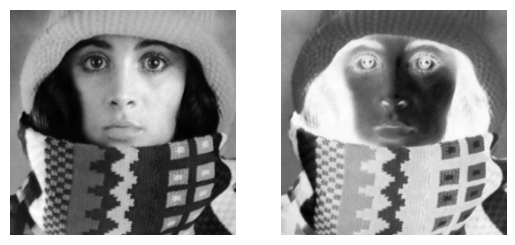

In [13]:
v_inv, psi_inv = invert_table()
g = np.interp(f, v_inv, psi_inv)
plt.subplot(1,2,1)
plt.imshow(f);
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(g);
plt.axis('off');

Next you have to define the table for interpolated table lookup that thresholds an image:

$$
\psi_{t}(v) = \begin{cases}
0 &: v<t\\
1 &: v\geq t
\end{cases}
$$

In [ ]:
def threshold_table(t):
    eps = 1e-6 # Choose suitably small epsilon to simulate discontinuity.
    return [0, t-eps, t, 1], [0, 0, 1, 1]

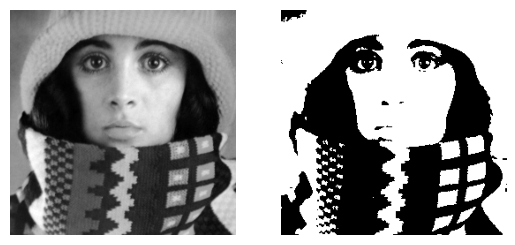

In [15]:
v_t, psi_t = threshold_table(0.5)
plt.subplot(1,2,1)
plt.imshow(f)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.interp(f, v_t, psi_t))
plt.axis('off');

# Histogram Equalization

In the lecture notes the histogram equalization operation for an image with gray values in the range from zero to one is given as the point operator defined with the function:
$$
\psi(v) = H_f(v)
$$
where $H_f$ is the normalized cumulative histogram of the image $f$.

In [16]:
def histogram_equalization(f, bins=100):
    h, be = np.histogram(f, range=(0,1), bins=bins)
    H = np.cumsum(h.astype(float)/sum(h))
    v = be
    psi = np.hstack(([0], H))
    return np.interp(f, v, psi)

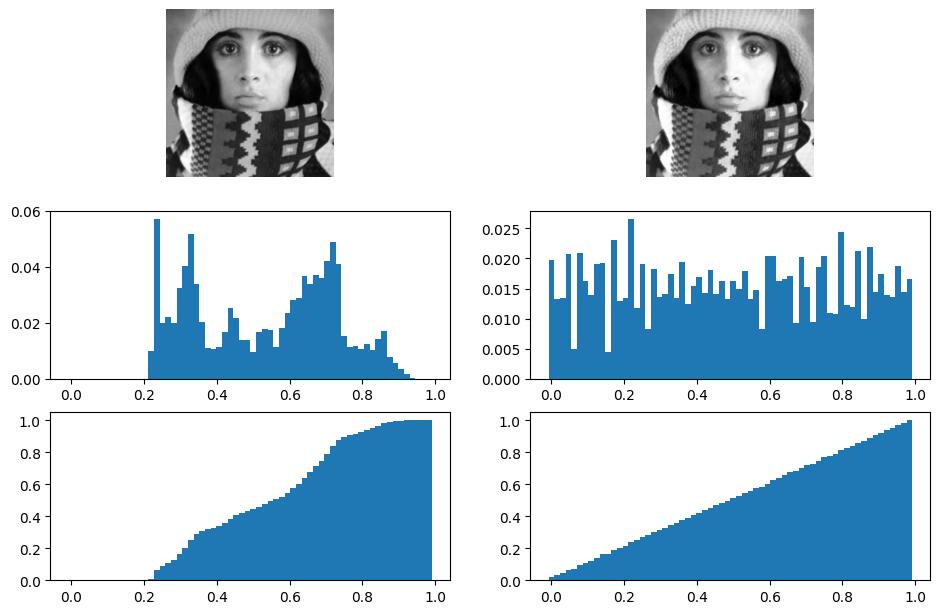

In [17]:
bins = 64
f = plt.imread('trui.png')
plt.subplot(321)
plt.imshow(f)
plt.axis('off')

plt.subplot(322)
g = histogram_equalization(f, bins=bins)
plt.imshow(g)
plt.axis('off')

plt.subplot(323)
h_f, be_f = np.histogram(f, range=(0,1), bins=bins)
h_f = h_f/np.sum(h_f)
plt.bar(be_f[:-1], h_f, width=be_f[1]-be_f[0]);

plt.subplot(324)
h_g, be_g = np.histogram(g, range=(0,1), bins=bins)
h_g = h_g/np.sum(h_g)
plt.bar(be_g[:-1], h_g, width=be_g[1]-be_g[0])

plt.subplot(325)
H_f = np.cumsum(h_f)
plt.bar(be_f[:-1], H_f, width=be_f[1]-be_f[0])
plt.subplot(326)
H_g = np.cumsum(h_g)
plt.bar(be_g[:-1], H_g, width=be_g[1]-be_g[0]);
plt.subplots_adjust(bottom=0.01, top=1.2, right=1.5)

In order to do the histogram equilization on an 8 bit image (uint8 data type) you have to write the function ``histogram_equilization_table``. In that function you will need the histogram of the 8bit image. Instead of using the ``histogram`` function, it is better in this case to use the ``bincount`` function from numpy. Be sure to set the ``minlength`` parameter!


In [ ]:
def histogram_equalization_table(f):
    """return the lookup table psi_he for the histogram
    equalization of an image f (dtype=uint8). Note that the table
    should have shape (256,) and dtype=uint8"""

    hist = np.bincount(f.flatten(), minlength=256)

    hist_sum = np.cumsum(hist)
    hist_normalized = (hist_sum - np.min(hist_sum)) * 255 / (np.max(hist_sum) - np.min(hist_sum))

    return hist_normalized.astype(np.uint8)

histogram_equalization_table(f)

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   2,   5,   8,  11,  17,  17,
        18,  20,  22,  23,  25,  26,  27,  28,  30,  31,  32,  34,  36,
        38,  41,  42,  44,  48,  51,  54,  58,  61,  64,  67,  69,  71,
        73,  74,  76,  77,  78,  79,  79,  80,  81,  82,  82,  83,  84,
        84,  85,  86,  87,  87,  89,  90,  91,  92,  94,  96,  97,  99,
       100, 102, 103, 104, 105, 106, 106, 107, 108, 109, 110, 110, 111,
       112, 112, 113, 114, 115, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 126, 127, 128, 129, 131, 132, 133, 134, 136, 137, 139,
       141, 142, 144, 146, 147, 148, 151, 153, 156, 159, 161, 163, 165,
       167, 169, 171, 174, 176, 179, 181, 183, 185, 188, 190, 19

## Histogram Equalization in Practice

Make several (at least 4) pictures of the same scene/object from different points of view. Most likely the overall intensity distribution in the images is not equal due to the automatic lighting correction in your camera. Use histogram equalization to correct for this and comment on whether it does the intended job. In your notebook you have to show a 2 x n ‘matrix’ of images, in the top row the original images and in the bottom row the equalized images.

Your camera probably makes color images. Equalization as discussed works on gray value images (black and white images). You can use the function rgb2gray from sklearn.color to make black-and-white images out of your color images.

Put the images into the same directory as the notebook, and open them e.g. with `plt.imread`. When uploading your assignment, you can also submit the images: they will be placed in the same directory as your code when the code is run.


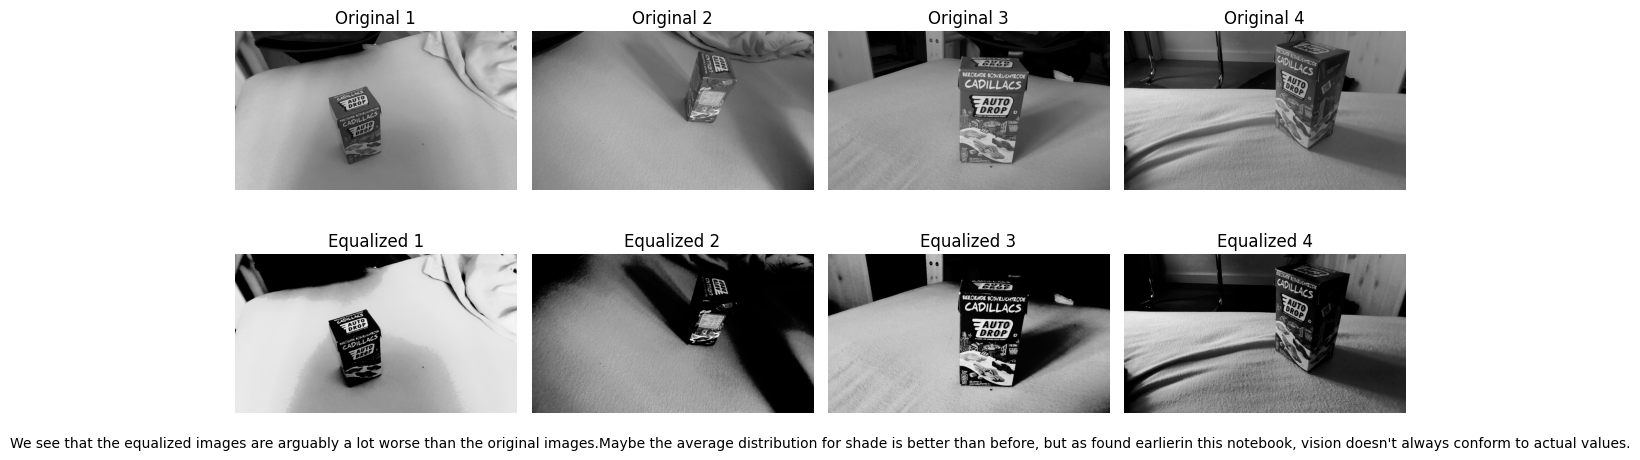

In [ ]:
from skimage.color import rgb2gray

# Load images of autodrop
colour_images = np.array([plt.imread(f"autodrop_{i}.png") for i in range(1, 5)])
bw_images = (rgb2gray(colour_images)*255).astype(np.uint8)

# Equalize the black and white images
processed_images = []
for img in bw_images:
    table = histogram_equalization_table(img)
    processed = table[img]
    processed_images.append(processed)
processed_images = np.array(processed_images)

# Plot the results
fig, axes = plt.subplots(2, len(processed_images), figsize=(12, 5))
for i in range(len(processed_images)):
    axes[0, i].imshow(bw_images[i], cmap='gray')
    axes[0, i].set_title(f"Original {i+1}")
    axes[0, i].axis('off')

    axes[1, i].imshow(processed_images[i], cmap='gray')
    axes[1, i].set_title(f"Equalized {i+1}")
    axes[1, i].axis('off')

txt="We see that the equalized images are arguably a lot worse than the original images." \
    "Maybe the average distribution for shade is better than before, but as found earlier" \
    "in this notebook, vision doesn't always conform to actual values."
fig.text(.5, .05, txt, ha='center')
plt.tight_layout()
plt.show()

Bonus: a simple way to use equalization on color images (and have a color image as the result) is to first convert the color image to a colorspace that explicitly encodes the luminance (the gray value) and the color componenent. One example is the function rgb2hsv from sklearn.color. HSV stands for Hue, Saturation and Value, where value is the gray value component. Equalization of color images then amounts to: convert a rgb image into a hsv image, then equalize the v component and then convert the new hsv image back to rgb (with hsv2rgb).

In [ ]:
from skimage.color import rgb2hsv, hsv2rgb

def histogram_equalization_rgb(f):
    # YOUR CODE HERE (Replace this and the following line with your code)
    raise NotImplementedError()

# Assignment 1.2: Bilinear interpolation

In many image processing applications you have access to a number of image transformation methods. These include rotating, stretching and even shearing an image.

These methods can be used to create some artistic effect, but they are also useful in correcting things like camera rotation, perspective distortions, etc, that were introduced when the picture was taken.

The input for these methods is always a quadrilateral region of a discrete image $F$. That means that you only know the intensity values at discrete integral pixel positions.
The output consists of a rectangular image $G$ with axes aligned with the Cartesian coordinate axes $x$ and $y$.

In an arbitrary image transformation, there is no guarantee that an "input"-pixel will be positioned at a pixel in the "output" image as well. Rather, most of the time your output image pixels will "look at" image positions in the input image, which are "between" pixels.
<table><tr> 
    <td> <img src="attachment:pixels_orig.png"></td>
<td> <img src="attachment:pixels_rotated.png"></td>
<td> <img src="attachment:pixels_both.png"></td>
</tr></table>

So you need access to intensity values which are not on the sampling grid of the original image, *e.g.* the intensitiy value at position (6.4, 7.3).

In this Exercise you will examine and implement interpolation techniques which solve this problem.
In a later assignment you will implement image transformations employing these techniques, such as rotations and projective transformations. This requires determining the desired transformation from the image data or from user input.

The relevant theorie for this assignment can be found in the lecture notes in [section 1.4](https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/LectureNotes/IP/Images/ImageInterpolation.html) and in the related theorie questions on ANS.

## Interpolation

The transformation algorithm needs a way to access the original image $F$ in
locations that are not on the sampling grid. We thus need a function pixelValue
that returns the value in the location $(x,y)$ even for non-integer coordinate
values.

### A note on indexing

There are multiple ways to interpret coordinates in an image. In mathematics, the x-axis usually goes right, and the y-axis goes up. If you have an image file `image`, typically `image[x]` selects a row, and `image[x][y]` then selects a column from that row. That means that the x-axis goes *down*, and the y-axis goes *right*.
Another way to do it is to interpret the pixel at coordinates $(x, y)$ as `image[y][x]`: then the x-axis goes right, and the y-axis goes down. (This is almost the same as the standard mathematical way of doing things, except the y-axis now goes down instead of up.) This is the convention we will be applying in this and future notebooks: in particular, the `pixel_value` function will now have inputs `F, y, x` rather than `F, x, y`, and in the case when `y, x` are integers in the domain of `F` it should now return `F[y][x]`.


Write a Python function `pixelValue` that returns the value of a pixel at real-valued coordinates $(x, y)$. Fill out the template given in the following cell.

You should implement nearest neighbour interpolation (`interpolation_method = 'nearest'`) and
bilinear interpolation (`interpolation_method = 'bilinear'`), as are described in the syllabus. Take the necessary steps to deal with the "border problem" (*i.e.* implement the function `inImage`). For now you do not yet have to implement any of the other `border_methods`. Instead for now we will simple use the `'constant'` `border_method` to return `cval` when we encounter a point outside of the image. 

In [ ]:
def in_image(image_shape, y, x):
    # YOUR CODE HERE (Replace this and the following line with your code)
    raise NotImplementedError()

def pixel_value(F, y, x, interpolation_method='nearest',
                border_method='constant', cval=0):
    if not in_image(F.shape, y, x):
        if border_method == 'constant':
            return cval
        elif border_method == 'closest':
            # YOUR CODE HERE (Replace this and the following line with your code)
            raise NotImplementedError()
        elif border_method == 'mirror':
            # YOUR CODE HERE (Replace this and the following line with your code)
            raise NotImplementedError()
        elif border_method == 'wrap':
            # YOUR CODE HERE (Replace this and the following line with your code)
            raise NotImplementedError()

    if interpolation_method == 'nearest':
        # YOUR CODE HERE (Replace this and the following line with your code)
        raise NotImplementedError()
    elif interpolation_method == 'bilinear':
        # YOUR CODE HERE (Replace this and the following line with your code)
        raise NotImplementedError()


In [ ]:
from PIL import Image
import numpy as np

# The first time you run these tests, the code downloads the standard computer vision example image "trui.png".
try:
    im = Image.open("trui.png")
except FileNotFoundError:
    import requests
    image_file = requests.get("https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_images/trui.png")
    open("trui.png", "wb").write(image_file.content)
    im = Image.open("trui.png")
image = np.array(im)

assert image.shape == (256, 256), "Did you download the correct image?"
assert in_image(image.shape, 0, 0)
assert not in_image(image.shape, -0.5, -0.5)
assert in_image(image.shape, image.shape[0] - 1, image.shape[1] - 1)
assert not in_image(image.shape, image.shape[0] - 0.5, image.shape[1] - 0.5)
assert in_image(image.shape, 0.5, 0.5)
assert in_image(image.shape, 0, image.shape[1]/2)
assert in_image(image.shape, image.shape[0]/3, image.shape[1]/1.5)
assert not in_image(image.shape, image.shape[0] + 10, image.shape[1] - 5)

In [ ]:
from PIL import Image
import numpy as np
from math import isclose
image = np.array(Image.open("trui.png"))

sample_points = [(0, 0), (20, 20), (32.3, 39.6), (100.7, 21.2), (14.9, 142.9),
                 (142.2, 98.1), (-2, 3), (1000.3, 20.5)]
nearest_results = [115, 143, 186, 176, 188, 149, 0, 0]

for (y, x), v in zip(sample_points, nearest_results):
    assert isclose(pixel_value(image, y, x, interpolation_method='nearest'), v), \
        f"For method nearest, and input point ({y},{x}), you give result " \
        f"{pixel_value(image, y, x, interpolation_method='nearest')} instead of {v}."



In [ ]:
from PIL import Image
import numpy as np
from math import isclose
image = np.array(Image.open("trui.png"))

sample_points = [(0, 0), (20, 20), (32.3, 39.6), (100.7, 21.2), (14.9, 142.9),
                 (142.2, 98.1), (-2, 3), (1000.3, 20.5)]
bilinear_results = [115, 143, 184.24, 175.64, 187.7, 148.56, 0, 0]

for (y, x), v in zip(sample_points, bilinear_results):
    assert isclose(pixel_value(image, y, x, interpolation_method='bilinear'), v), \
        f"For method bilinear, and input point ({y},{x}), you give result " \
        f"{pixel_value(image, y, x, interpolation_method='bilinear')} instead of {v}."



Perform additional tests of the function `pixel_value` by using the `profile` function that samples an image at `n` equidistant points along a line from $(x_0, y_0)$ to $(x_1, y_1)$. Create a single plot that shows the profile along the same line, using both nearest-neighbor and bilinear interpolation, that clearly shows the difference between the two methods. (Hint: if you take `n` high enough, the difference should be clear.)

In [ ]:
def profile(image, y0, x0, y1, x1, n, method):
    xs = np.linspace(y0, y1, n)
    ys = np.linspace(x0, x1, n)
    return np.array([pixel_value(image, y, x, interpolation_method=method) for y, x in zip(ys, xs)])

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
image = np.array(Image.open("trui.png"))

# YOUR CODE HERE (Replace this and the following line with your code)
raise NotImplementedError()

Now return to the `pixel_value` function and implement the different `border_methods` for the border problem as described in [section 1.5](https://rvdboomgaard.github.io/ComputerVision_LectureNotes/LectureNotes/IP/Images/ImageExtrapolation.html) of the lecture notes.

Experiment with these new methods and describe your results.